##### import libary

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, fisher_exact
import utility, importlib

##### This analysis use fitness info sheet and generation wise allele count information sheet for each unique mutation from ecoli metasheet.

Generation wise fitness information --> Available in Fitness2_experimental sheet of ecoli metadata
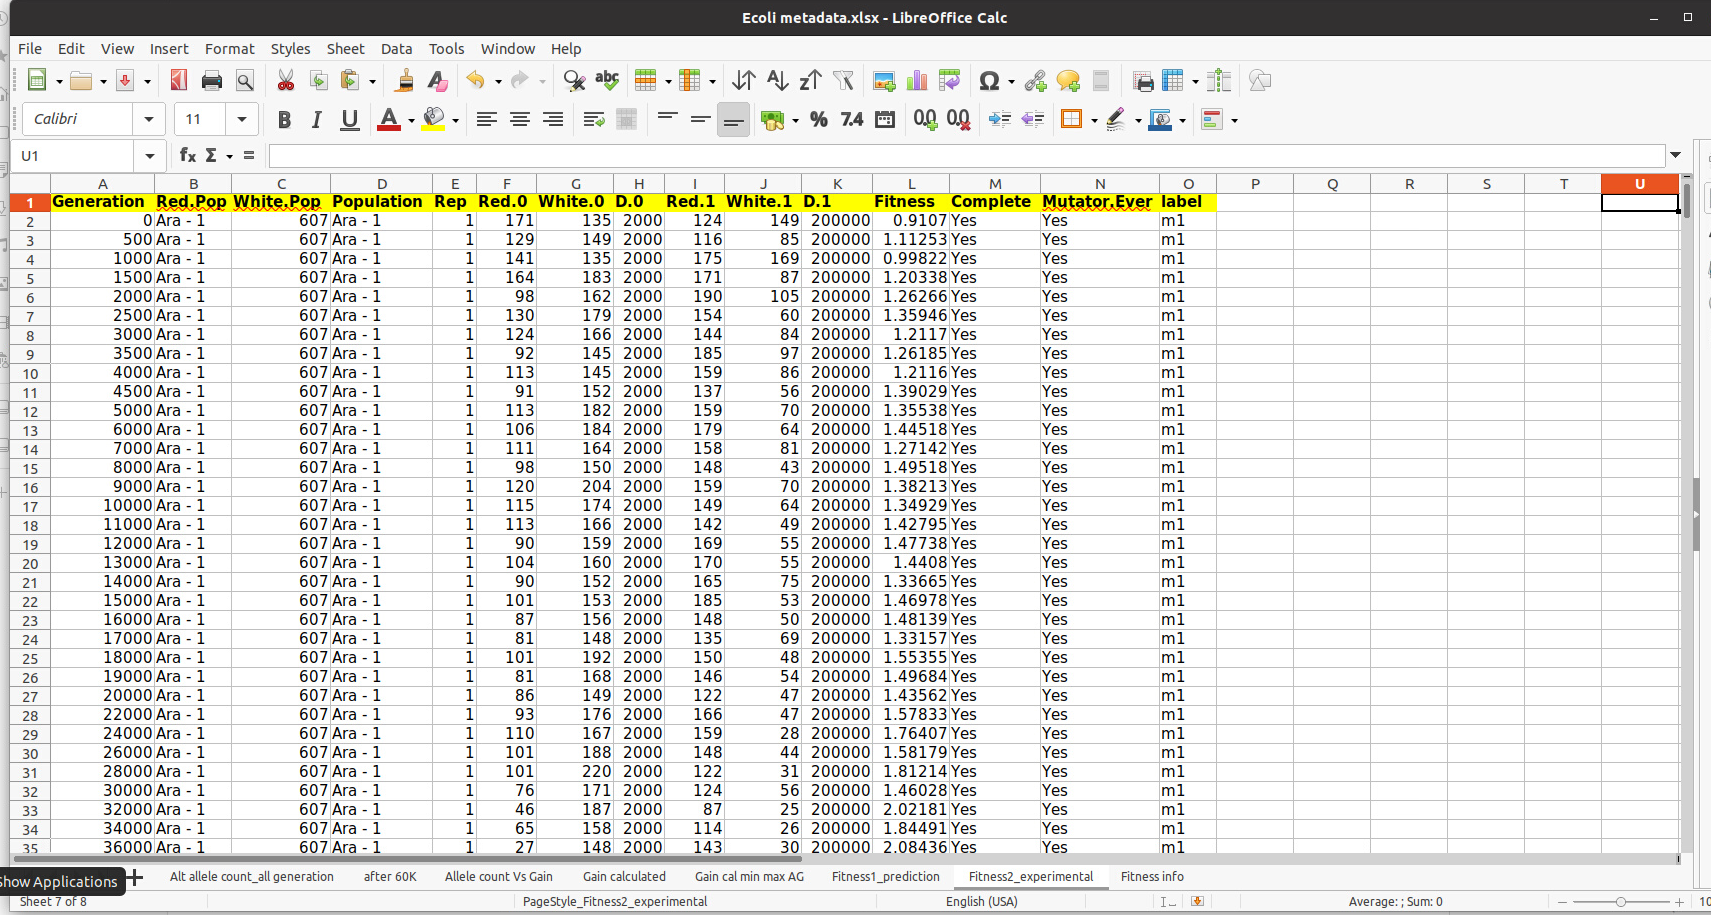

Generation wise allele count information --> Available in Alt allele count_all generation sheet of ecoli metadata
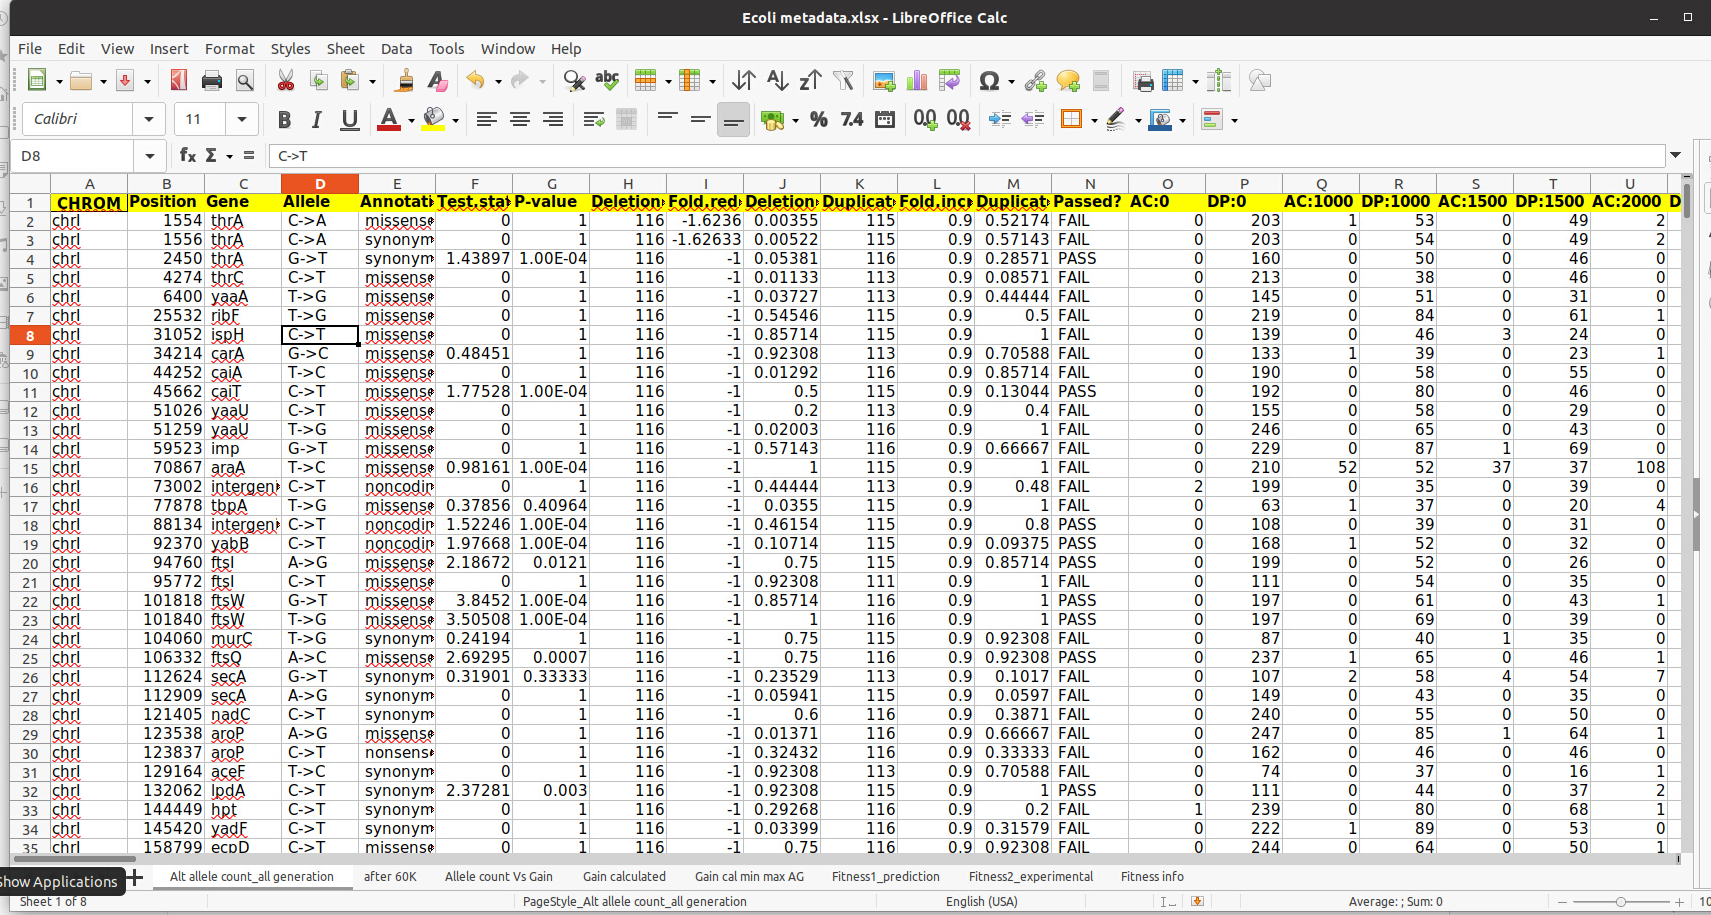

Gain information --> Available in Gain calculated sheet of ecoli metadata
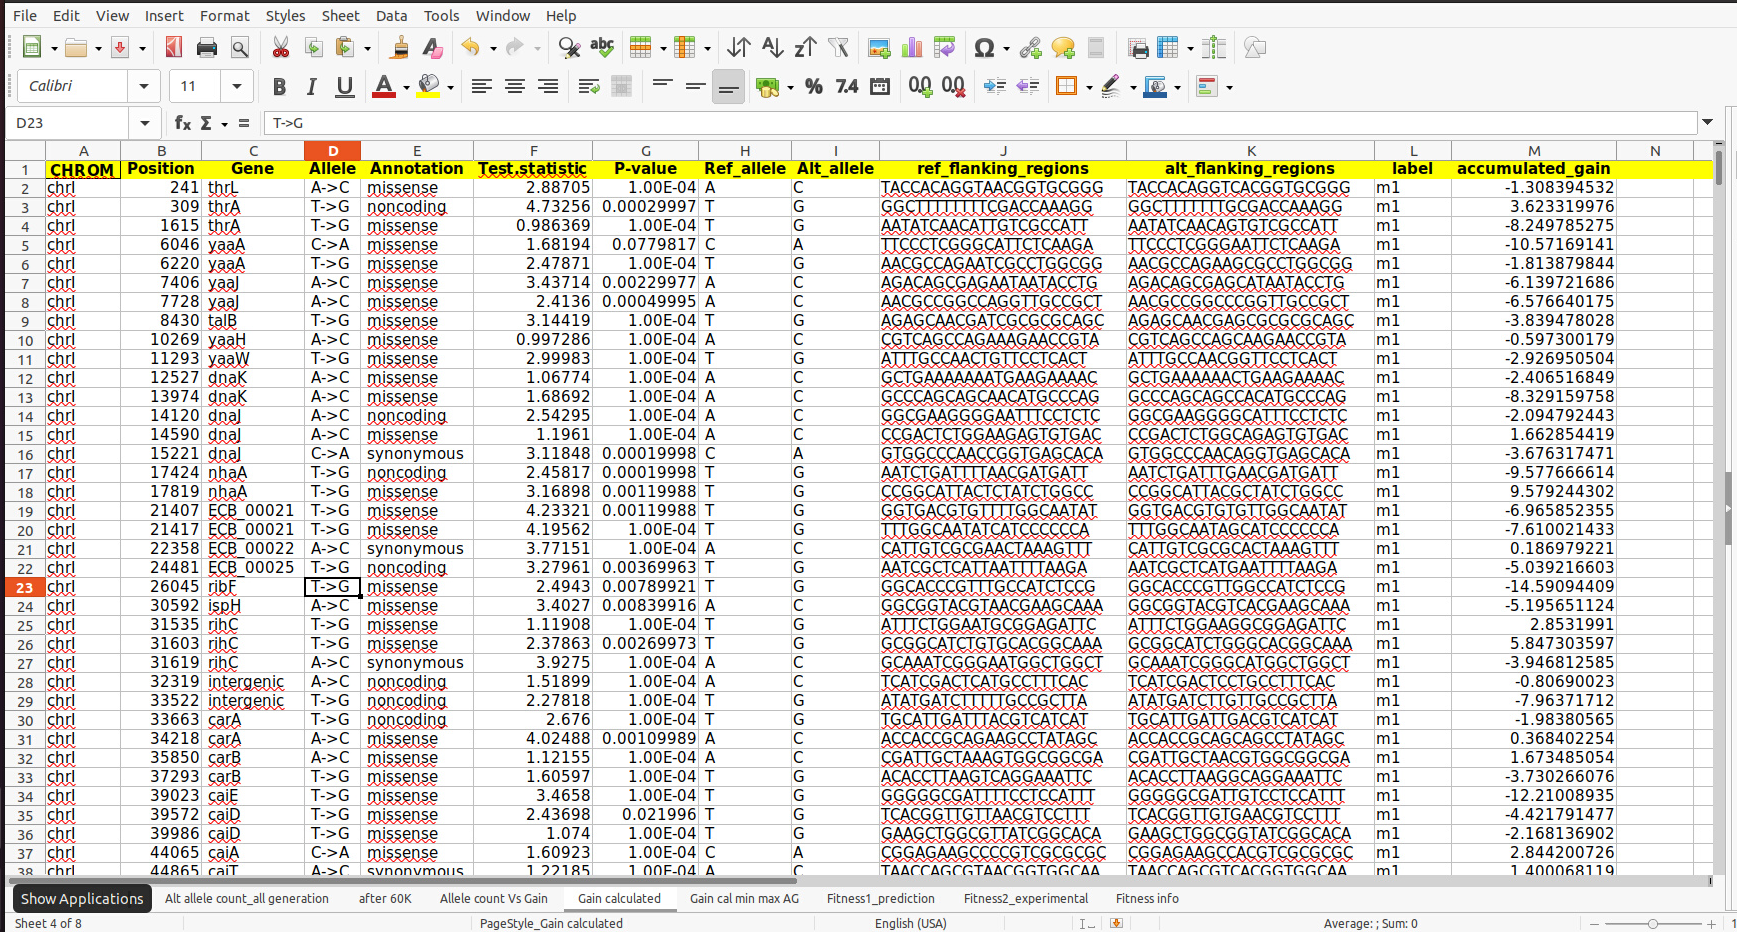

##### Read fitness data from metadata

In [2]:
df_Fitness2_experimental = pd.read_excel("Ecoli metadata.xlsx", sheet_name="Fitness2_experimental")
df_Fitness2_experimental = df_Fitness2_experimental.rename(columns={'label ': 'label'})
df_Fitness2_experimental.head()

Generation  Red.Pop White.Pop Population  Rep   Fitness Complete  \
0           0  Ara - 1       607    Ara - 1    1  0.910700      Yes   
1         500  Ara - 1       607    Ara - 1    1  1.112534      Yes   
2        1000  Ara - 1       607    Ara - 1    1  0.998220      Yes   
3        1500  Ara - 1       607    Ara - 1    1  1.203381      Yes   
4        2000  Ara - 1       607    Ara - 1    1  1.262659      Yes   

  Mutator.Ever label  
0          Yes    m1  
1          Yes    m1  
2          Yes    m1  
3          Yes    m1  
4          Yes    m1

##### check if any duplicate row is present in fitness sheet

In [3]:
df_Fitness2_experimental[df_Fitness2_experimental.duplicated()] # No duplicate row found

Empty DataFrame
Columns: [Generation, Red.Pop, White.Pop, Population, Rep, Fitness, Complete, Mutator.Ever, label]
Index: []

##### Read gain sheet data

In [4]:
df_Gain_calculated = pd.read_excel("Ecoli metadata.xlsx", sheet_name= "Gain calculated")

In [5]:
df_Gain_calculated.head()

CHROM  Position   Gene Allele  Annotation Ref_allele Alt_allele  \
0  chrI       241   thrL   A->C    missense          A          C   
1  chrI       309   thrA   T->G   noncoding          T          G   
2  chrI      1615   thrA   T->G    missense          T          G   
3  chrI      6046   yaaA   C->A    missense          C          A   
4  chrI      6220   yaaA   T->G    missense          T          G   

    ref_flanking_regions   alt_flanking_regions label  accumulated_gain  
0  TACCACAGGTAACGGTGCGGG  TACCACAGGTCACGGTGCGGG    m1         -1.308395  
1  GGCTTTTTTTTCGACCAAAGG  GGCTTTTTTTGCGACCAAAGG    m1          3.623320  
2  AATATCAACATTGTCGCCATT  AATATCAACAGTGTCGCCATT    m1         -8.249785  
3  TTCCCTCGGGCATTCTCAAGA  TTCCCTCGGGAATTCTCAAGA    m1        -10.571691  
4  AACGCCAGAATCGCCTGGCGG  AACGCCAGAAGCGCCTGGCGG    m1         -1.813880

##### check for duplicate w.r.t Chromosome, Position, Gene,Allele, Annotation, Reference allele, Alternate allele,label in the gain sheet

In [6]:
df_Gain_calculated[df_Gain_calculated.duplicated(subset=['CHROM','Position', 'Gene',
 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'])]

CHROM  Position   Gene Allele Annotation Ref_allele Alt_allele  \
19663  chrI    450000   ylaB   A->G   missense          A          G   

        ref_flanking_regions   alt_flanking_regions label  accumulated_gain  
19663  GTTGAAGCCCAGGTGATGATC  GTTGAAGCCCGGGTGATGATC    p3         -6.546367

##### Drop duplicates from the gain sheet

In [7]:
df_Gain_calculated.drop_duplicates(subset=['CHROM','Position', 'Gene',
 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
df_Gain_calculated.reset_index(inplace=True, drop=True)
df_Gain_calculated.head()

CHROM  Position   Gene Allele  Annotation Ref_allele Alt_allele  \
0  chrI       241   thrL   A->C    missense          A          C   
1  chrI       309   thrA   T->G   noncoding          T          G   
2  chrI      1615   thrA   T->G    missense          T          G   
3  chrI      6046   yaaA   C->A    missense          C          A   
4  chrI      6220   yaaA   T->G    missense          T          G   

    ref_flanking_regions   alt_flanking_regions label  accumulated_gain  
0  TACCACAGGTAACGGTGCGGG  TACCACAGGTCACGGTGCGGG    m1         -1.308395  
1  GGCTTTTTTTTCGACCAAAGG  GGCTTTTTTTGCGACCAAAGG    m1          3.623320  
2  AATATCAACATTGTCGCCATT  AATATCAACAGTGTCGCCATT    m1         -8.249785  
3  TTCCCTCGGGCATTCTCAAGA  TTCCCTCGGGAATTCTCAAGA    m1        -10.571691  
4  AACGCCAGAATCGCCTGGCGG  AACGCCAGAAGCGCCTGGCGG    m1         -1.813880

##### Read allele count and generation data from metasheet

In [8]:
df_Alt_allele_count_all_generation = pd.read_excel("Ecoli metadata.xlsx", sheet_name= "Alt allele count_all generation")
df_Alt_allele_count_all_generation.head()

CHROM  Position   Gene Allele   Annotation  AC:0  AC:1000  AC:1500  AC:2000  \
0  chrI      1554   thrA   C->A     missense     0        1        0        2   
1  chrI      1556   thrA   C->A   synonymous     0        0        0        2   
2  chrI      2450   thrA   G->T   synonymous     0        0        0        0   
3  chrI      4274   thrC   C->T     missense     0        0        0        0   
4  chrI      6400   yaaA   T->G     missense     0        0        0        0   

   AC:2500  ...  DP:58500  AC:59000  DP:59000  AC:59500  DP:59500  AC:60000  \
0      1.0  ...     154.0       1.0       5.0       0.0      77.0       0.0   
1      0.0  ...     150.0       0.0       6.0       0.0      76.0       0.0   
2      0.0  ...     129.0       4.0       4.0      67.0      67.0       8.0   
3      0.0  ...      97.0       0.0       2.0       0.0      52.0       0.0   
4      2.0  ...      67.0       0.0       2.0       0.0      45.0       0.0   

   DP:60000  Ref_allele  Alt_allele  label  
0       4.0           C           A     p1  
1       4.0           C           A     p1  
2       8.0           G           T     p1  
3       3.0           C           T     p1  
4       5.0           T           G     p1  

[5 rows x 130 columns]

##### delete duplicate row in df_Alt_allele_count_all_generation dataframe where duplicate indicate when ['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'] are same in mutiple row

In [9]:
df_Alt_allele_count_all_generation.drop_duplicates(subset=['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label'], inplace=True)
df_Alt_allele_count_all_generation.reset_index(inplace=True, drop=True)
df_Alt_allele_count_all_generation.head()

CHROM  Position   Gene Allele   Annotation  AC:0  AC:1000  AC:1500  AC:2000  \
0  chrI      1554   thrA   C->A     missense     0        1        0        2   
1  chrI      1556   thrA   C->A   synonymous     0        0        0        2   
2  chrI      2450   thrA   G->T   synonymous     0        0        0        0   
3  chrI      4274   thrC   C->T     missense     0        0        0        0   
4  chrI      6400   yaaA   T->G     missense     0        0        0        0   

   AC:2500  ...  DP:58500  AC:59000  DP:59000  AC:59500  DP:59500  AC:60000  \
0      1.0  ...     154.0       1.0       5.0       0.0      77.0       0.0   
1      0.0  ...     150.0       0.0       6.0       0.0      76.0       0.0   
2      0.0  ...     129.0       4.0       4.0      67.0      67.0       8.0   
3      0.0  ...      97.0       0.0       2.0       0.0      52.0       0.0   
4      2.0  ...      67.0       0.0       2.0       0.0      45.0       0.0   

   DP:60000  Ref_allele  Alt_allele  label  
0       4.0           C           A     p1  
1       4.0           C           A     p1  
2       8.0           G           T     p1  
3       3.0           C           T     p1  
4       5.0           T           G     p1  

[5 rows x 130 columns]

#### Read esm score sheet available from previous analysis

In [10]:
df_esm = pd.read_excel("DNA_PRT_Ecolimeta_true_SNP_prt_mapped_esm1b_score_fresh_compl.xlsx")
# df_esm = pd.read_excel("/home/abhishekh/Downloads/Final_esm1b_variant.xlsx")
df_esm.head()

Position  Gene Allele Ref_allele Alt_allele Annotation label  Start    End  \
0       241  thrL   A->C          A          C   missense    m1    190    255   
1      1615  thrA   T->G          T          G   missense    m1    336   2798   
2      8430  talB   T->G          T          G   missense    m1   8236   9189   
3     12527  dnaK   A->C          A          C   missense    m1  12161  14077   
4     13974  dnaK   A->C          A          C   missense    m1  12161  14077   

  Strand  ... has_space                                        WT_aa_made2  \
0      +  ...     False                              MKRISTTITTTITITTGNGAG   
1      +  ...     False  MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...   
2      +  ...     False  MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...   
3      +  ...     False  MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...   
4      +  ...     False  MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...   

  comparison2                                        Mut_aa_made    SNP  \
0        True                              MKRISTTITTTITITTGHGAG   N18H   
1        True  MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...  I427S   
2        True  MTDKLTSLRQYTTVVADTGDIAAMKLYQPQDATTNPSLILNAAQIP...   D65E   
3        True  MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...  M123L   
4        True  MGKIIGIDLGTTNSCVAIMDGTTPRVLENAEGDRTTPSIIAYTQDG...  Q605P   

     seq_id_x      universal_id    seq_id_y  mut_name  esm_score  
0    241_thrL     241_thrL_N18H    241_thrL      N18H  -4.279933  
1   1615_thrA   1615_thrA_I427S   1615_thrA     I427S -11.530375  
2   8430_talB    8430_talB_D65E   8430_talB      D65E  -5.331029  
3  12527_dnaK  12527_dnaK_M123L  12527_dnaK     M123L  -4.669276  
4  13974_dnaK  13974_dnaK_Q605P  13974_dnaK     Q605P  -7.992450  

[5 rows x 26 columns]

##### delete duplicate row from esm dataframe where duplicate indicate when ["Position",  "Gene", "label", "Allele"] are same in mutiple row

In [11]:
df_esm_no_duplicates = df_esm[["Position",  "Gene", "label", "esm_score", "Allele"]].drop_duplicates(subset= ["Position",  "Gene", "label", "Allele"], keep='first')
df_esm_no_duplicates.dropna(inplace=True)
df_esm_no_duplicates.reset_index(inplace=True, drop=True)
df_esm_no_duplicates.head()

Position  Gene label  esm_score Allele
0       241  thrL    m1  -4.279933   A->C
1      1615  thrA    m1 -11.530375   T->G
2      8430  talB    m1  -5.331029   T->G
3     12527  dnaK    m1  -4.669276   A->C
4     13974  dnaK    m1  -7.992450   A->C

##### Merge gain dataframe and allele dataframe

In [12]:
df_complete = pd.merge(df_Alt_allele_count_all_generation, df_Gain_calculated, on=['CHROM',
 'Position','Gene','Allele','Annotation','Ref_allele','Alt_allele','label'], how = "left")
df_complete

CHROM  Position   Gene Allele   Annotation  AC:0  AC:1000  AC:1500  \
0      chrI      1554   thrA   C->A     missense     0        1        0   
1      chrI      1556   thrA   C->A   synonymous     0        0        0   
2      chrI      2450   thrA   G->T   synonymous     0        0        0   
3      chrI      4274   thrC   C->T     missense     0        0        0   
4      chrI      6400   yaaA   T->G     missense     0        0        0   
...     ...       ...    ...    ...          ...   ...      ...      ...   
36917  chrI   4509212   sgcC   C->T   synonymous     0        0        0   
36918  chrI   4532106   gntP   C->T   synonymous     0        0        0   
36919  chrI   4533490   uxuA   C->T     missense     0        0        0   
36920  chrI   4606154   yjjI   C->T     missense     0        0        0   
36921  chrI   4615842   nadR   A->T     missense     0        0       42   

       AC:2000  AC:2500  ...  AC:59500  DP:59500  AC:60000  DP:60000  \
0            2      1.0  ...       0.0      77.0       0.0       4.0   
1            2      0.0  ...       0.0      76.0       0.0       4.0   
2            0      0.0  ...      67.0      67.0       8.0       8.0   
3            0      0.0  ...       0.0      52.0       0.0       3.0   
4            0      2.0  ...       0.0      45.0       0.0       5.0   
...        ...      ...  ...       ...       ...       ...       ...   
36917        0      0.0  ...       0.0      31.0       0.0      44.0   
36918        0      1.0  ...       0.0      61.0       0.0      60.0   
36919        0      0.0  ...       0.0      49.0       1.0      79.0   
36920        0      0.0  ...       0.0      38.0       0.0      41.0   
36921       41     67.0  ...      61.0      61.0      73.0      73.0   

       Ref_allele  Alt_allele  label   ref_flanking_regions  \
0               C           A     p1  TGATGGTATGCGCACCTTGCG   
1               C           A     p1  ATGGTATGCGCACCTTGCGTG   
2               G           T     p1  AACCTGTGCTGCCCGCAGAGT   
3               C           T     p1  GAAACTGTTGCCATCGACGGC   
4               T           G     p1  GTATAGCGCGTGGTGGTCAAC   
...           ...         ...    ...                    ...   
36917           C           T     m6  CTGAGATTTGCGCACTTTCAC   
36918           C           T     m6  CGACGGACAGCGCCGCCACCA   
36919           C           T     m6  TTCCACGAAGCGGCGCACCTG   
36920           C           T     m6  CAGCGCGCGGCGGGCTTCGGC   
36921           A           T     m6  GATACCCGCGATCGCGCGTTG   

        alt_flanking_regions  accumulated_gain  
0      TGATGGTATGAGCACCTTGCG         -5.434794  
1      ATGGTATGCGAACCTTGCGTG         -6.463767  
2      AACCTGTGCTTCCCGCAGAGT         -2.942253  
3      GAAACTGTTGTCATCGACGGC         -7.823651  
4      GTATAGCGCGGGGTGGTCAAC        -11.175249  
...                      ...               ...  
36917  CTGAGATTTGTGCACTTTCAC         -6.535374  
36918  CGACGGACAGTGCCGCCACCA         -5.472303  
36919  TTCCACGAAGTGGCGCACCTG         -2.578430  
36920  CAGCGCGCGGTGGGCTTCGGC         -3.938429  
36921  GATACCCGCGTTCGCGCGTTG         -4.966243  

[36922 rows x 133 columns]

#### extract the column relavent for current analysis from allele count dataframe (all the generation wise allele count, 'CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label')

In [13]:
filtered_list = [item for item in df_complete if item.startswith("AC")] ## Fiter the column starting with "AC" which indicate allele count
filtered_list.extend(['CHROM','Position', 'Gene', 'Allele', 'Annotation', 'Ref_allele', 'Alt_allele','label', "accumulated_gain"]) ##Add other relavent information
df_allele_generation = df_complete[filtered_list]
df_allele_generation.head() # Get complete dataframe containing all generation wise allele count and other relavent column

AC:0  AC:1000  AC:1500  AC:2000  AC:2500  AC:3000  AC:4000  AC:4500  \
0     0        1        0        2      1.0        1        0        0   
1     0        0        0        2      0.0        3        0        0   
2     0        0        0        0      0.0        0        0        0   
3     0        0        0        0      0.0        1        0        0   
4     0        0        0        0      2.0        0        0        0   

   AC:5000  AC:5500  ...  AC:60000  CHROM  Position   Gene  Allele  \
0        0        0  ...       0.0   chrI      1554   thrA    C->A   
1        0        0  ...       0.0   chrI      1556   thrA    C->A   
2        0        0  ...       8.0   chrI      2450   thrA    G->T   
3        0        0  ...       0.0   chrI      4274   thrC    C->T   
4        0        0  ...       0.0   chrI      6400   yaaA    T->G   

    Annotation  Ref_allele  Alt_allele  label  accumulated_gain  
0     missense           C           A     p1         -5.434794  
1   synonymous           C           A     p1         -6.463767  
2   synonymous           G           T     p1         -2.942253  
3     missense           C           T     p1         -7.823651  
4     missense           T           G     p1        -11.175249  

[5 rows x 126 columns]

##### Define mutator and non mutator population

In [14]:
mutator_list = ['m1', 'm2', 'm3', 'm4', 'p3', 'p6']
non_mutator_list = ['p1', 'p2', 'p4', 'p5', 'm5', 'm6']

#### population wise mutation count
###### It shows the count of mutation for every population. It is evident from the counts that  the mutator has significantly higher number of mutation than non mutator.

In [15]:
print("The number of mutation present population wise :")
df_complete["label"].value_counts()

The number of mutation present population wise :


label
p6    11257
p3     5967
m1     4994
m4     4953
m2     3398
m3     3215
p1      957
m5      600
m6      475
p4      420
p5      355
p2      331
Name: count, dtype: int64

##### find the generations which have missing value

In [16]:
nan_columns = df_allele_generation.columns[df_allele_generation.isna().any()]
df_with_nan = df_allele_generation[nan_columns]
nan_counts = df_allele_generation.isna().sum()
nan_counts = nan_counts[nan_counts > 0]
print("\nNumber of NaN values in each column:")
print(nan_counts)


Number of NaN values in each column:
AC:2500      355
AC:15000    4953
AC:46500     331
AC:58000    3753
AC:58500     355
AC:59000     355
AC:59500     355
AC:60000     355
dtype: int64


#### drop the generations having having nan value

In [17]:
df_allele_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)
df_allele_generation.reset_index(inplace=True, drop = True)
df_allele_generation.head()

/tmp/ipykernel_701410/435986532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allele_generation.drop(nan_counts.index.tolist(), axis = 1, inplace=True)


AC:0  AC:1000  AC:1500  AC:2000  AC:3000  AC:4000  AC:4500  AC:5000  \
0     0        1        0        2        1        0        0        0   
1     0        0        0        2        3        0        0        0   
2     0        0        0        0        0        0        0        0   
3     0        0        0        0        1        0        0        0   
4     0        0        0        0        0        0        0        0   

   AC:5500  AC:6000  ...  AC:57500  CHROM  Position   Gene  Allele  \
0        0        0  ...         0   chrI      1554   thrA    C->A   
1        0        0  ...         0   chrI      1556   thrA    C->A   
2        0        0  ...        41   chrI      2450   thrA    G->T   
3        0        0  ...         0   chrI      4274   thrC    C->T   
4        0        0  ...         0   chrI      6400   yaaA    T->G   

    Annotation  Ref_allele  Alt_allele  label  accumulated_gain  
0     missense           C           A     p1         -5.434794  
1   synonymous           C           A     p1         -6.463767  
2   synonymous           G           T     p1         -2.942253  
3     missense           C           T     p1         -7.823651  
4     missense           T           G     p1        -11.175249  

[5 rows x 118 columns]

##### create dataset having all mutation info in proper form for easy calculation
##### Make a dataframe having column ['label', 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation', 'generation', 'allele count', 'generation_number']

In [18]:
data_all_copy = df_allele_generation.copy()
all_mutation = pd.DataFrame() # The all_mutation dataframe contain generation and population wise accumulated gain

for i in data_all_copy.columns[:-9]:
    new_df_tmp = pd.DataFrame()
    new_df = data_all_copy[data_all_copy.loc[:, i]!=0]
    new_df_tmp = new_df[["label", 'CHROM', 'Position', 'Gene', 'Allele', 'Annotation']]
    new_df_tmp.loc[:, "generation"] = i
    new_df_tmp.loc[:, "AG"] = new_df.loc[:, "accumulated_gain"]
    new_df_tmp.loc[:, "allele count"] = new_df.loc[:, i]
    all_mutation = pd.concat([all_mutation, new_df_tmp], axis = 0)
    
    
all_mutation.reset_index(inplace=True, drop=True)
all_mutation['generation_number'] = all_mutation['generation'].str.extract(r'(\d+)').astype(int)
for i in range(all_mutation.shape[0]):
    
    if all_mutation.loc[i, "label"] in mutator_list:
        all_mutation.loc[i, "mutator"] = "mutator"
    if all_mutation.loc[i, "label"] in non_mutator_list:
        all_mutation.loc[i, "mutator"] = "non mutator"

all_mutation.head()

/tmp/ipykernel_701410/3009267551.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_tmp.loc[:, "generation"] = i
/tmp/ipykernel_701410/3009267551.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_tmp.loc[:, "AG"] = new_df.loc[:, "accumulated_gain"]
/tmp/ipykernel_701410/3009267551.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

label CHROM  Position         Gene Allele   Annotation generation        AG  \
0    p1  chrI     73002   intergenic   C->T    noncoding       AC:0 -8.614562   
1    p1  chrI    144449          hpt   C->T   synonymous       AC:0 -7.918810   
2    p1  chrI    458736         kefA   C->T     missense       AC:0 -8.988104   
3    p1  chrI    524856         purE   G->A     missense       AC:0 -2.894726   
4    p1  chrI    557008    ECB_00513   C->T     missense       AC:0 -9.498170   

   allele count  generation_number      mutator  
0             2                  0  non mutator  
1             1                  0  non mutator  
2             1                  0  non mutator  
3             1                  0  non mutator  
4             2                  0  non mutator

##### remove white spaces from the columns of dataframes

In [19]:
df_esm_no_duplicates["Gene"] = df_esm_no_duplicates["Gene"] .str.strip()
all_mutation["Gene"] = all_mutation["Gene"] .str.strip()
df_esm_no_duplicates["Allele"] = df_esm_no_duplicates["Allele"] .str.strip()
all_mutation["Allele"] = all_mutation["Allele"] .str.strip()

#### merge esm score and allele count sheet in single dataframe

In [20]:
all_mutation_with_esm_1b_score = pd.merge(all_mutation, df_esm_no_duplicates, on = ["label", 'Position', "Gene", 'Allele'], how="left")
all_mutation_with_esm_1b_score_drop_na = all_mutation_with_esm_1b_score.dropna(subset=["esm_score"])
all_mutation_with_esm_1b_score_drop_na.reset_index(inplace=True, drop=True)
all_mutation_with_esm_1b_score_drop_na.head()

label CHROM  Position  Gene Allele Annotation generation        AG  \
0    p1  chrI    458736  kefA   C->T   missense       AC:0 -8.988104   
1    p1  chrI    524856  purE   G->A   missense       AC:0 -2.894726   
2    p1  chrI   1156229   rne   G->A   missense       AC:0 -6.276873   
3    p1  chrI   1507395  ydcE   A->G   missense       AC:0 -1.912514   
4    p1  chrI   2538060  yfgC   G->A   missense       AC:0 -7.050116   

   allele count  generation_number      mutator  esm_score  
0             1                  0  non mutator  -6.072133  
1             1                  0  non mutator -12.324469  
2             1                  0  non mutator  -3.581650  
3             1                  0  non mutator  -5.345155  
4             1                  0  non mutator -11.184139

##### Median esm score vs generation for all type of population
###### It is the line plots showing median esm scores associated with mutations (with a shaded area indicating the 95% confidence interval) for mutators, non-mutators, and their combination (Good et al. 2017). The mutator group consistently shows an upward trend in median LLR scores, while the non-mutator group exhibits a minor increase in median LLR scores towards the end of the trajectory, with substantial intermittent fluctuations. Mutators and non-mutators, when combined, show a steady increase in median LLR scores. Combining mutators and non-mutators reveals a steady rise in median LLR scores, primarily due to the significantly higher mutation frequency in mutators.

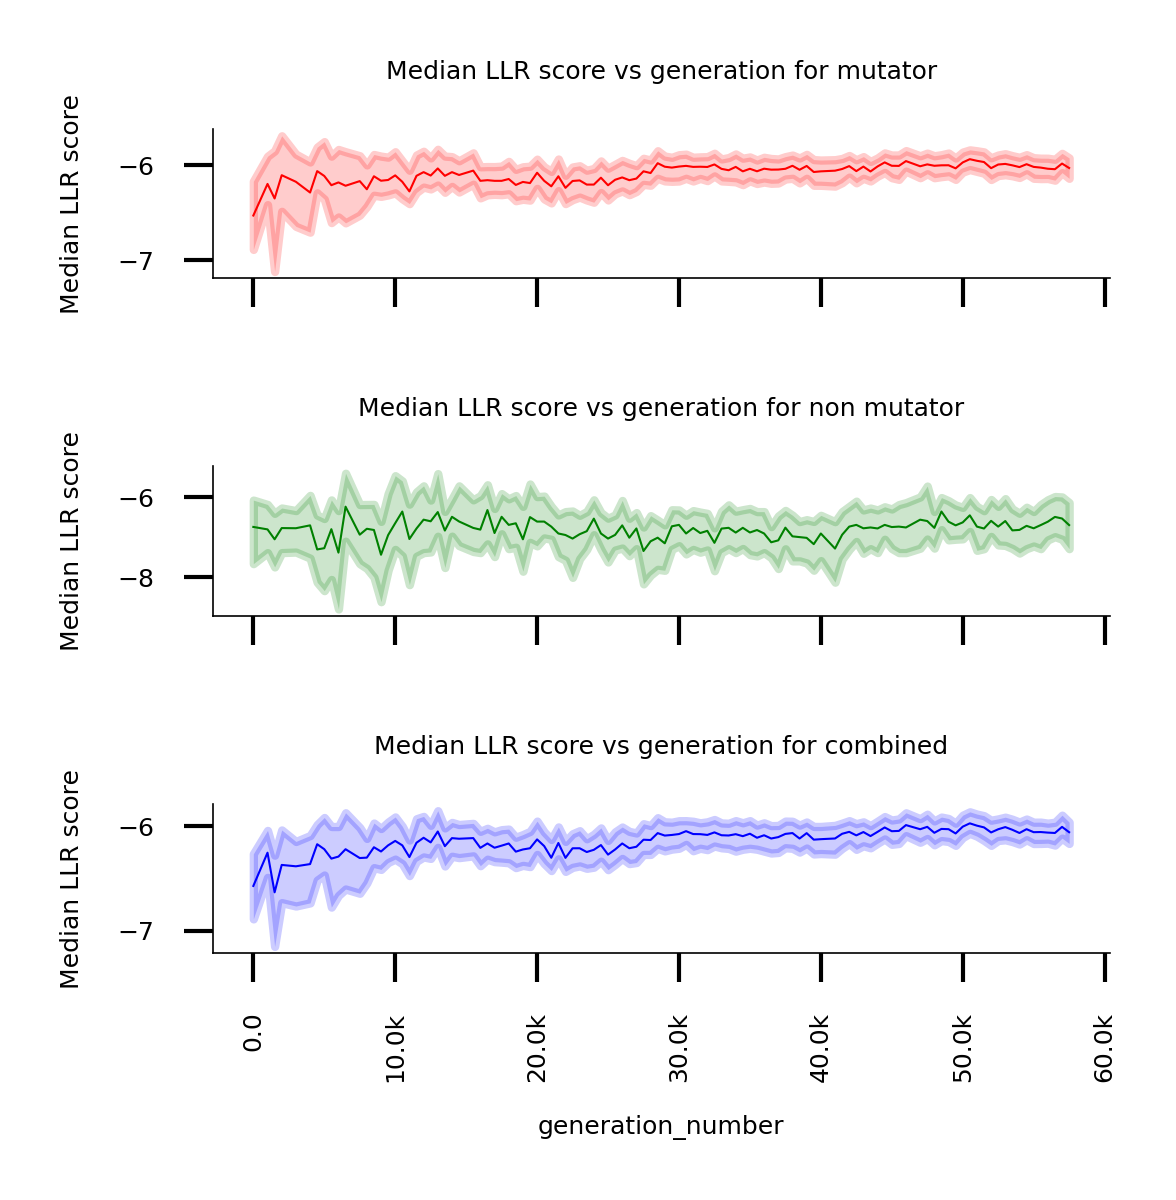

In [21]:
ax = utility.return_mutator_non_mutator_column_name_wise_graph_together(all_mutation_with_esm_1b_score_drop_na, mutator_list, non_mutator_list, column_name = "esm_score", fontsize = 3);
ax[0].set_title("Median LLR score vs generation for mutator", fontsize = 3);
ax[1].set_title("Median LLR score vs generation for non mutator", fontsize = 3);
ax[2].set_title("Median LLR score vs generation for combined", fontsize = 3);
ax[0].set_ylabel("Median LLR score", fontsize = 3);
ax[1].set_ylabel("Median LLR score", fontsize = 3);
ax[2].set_ylabel("Median LLR score", fontsize = 3);

##### Median Accumulated gain vs generation line plot with 95% confidence interval
###### It shows the line plot of median of accumulated gain vs generation where the the shaaded region indicate 95% confident interval around median for both mutator and non mutator and overall.

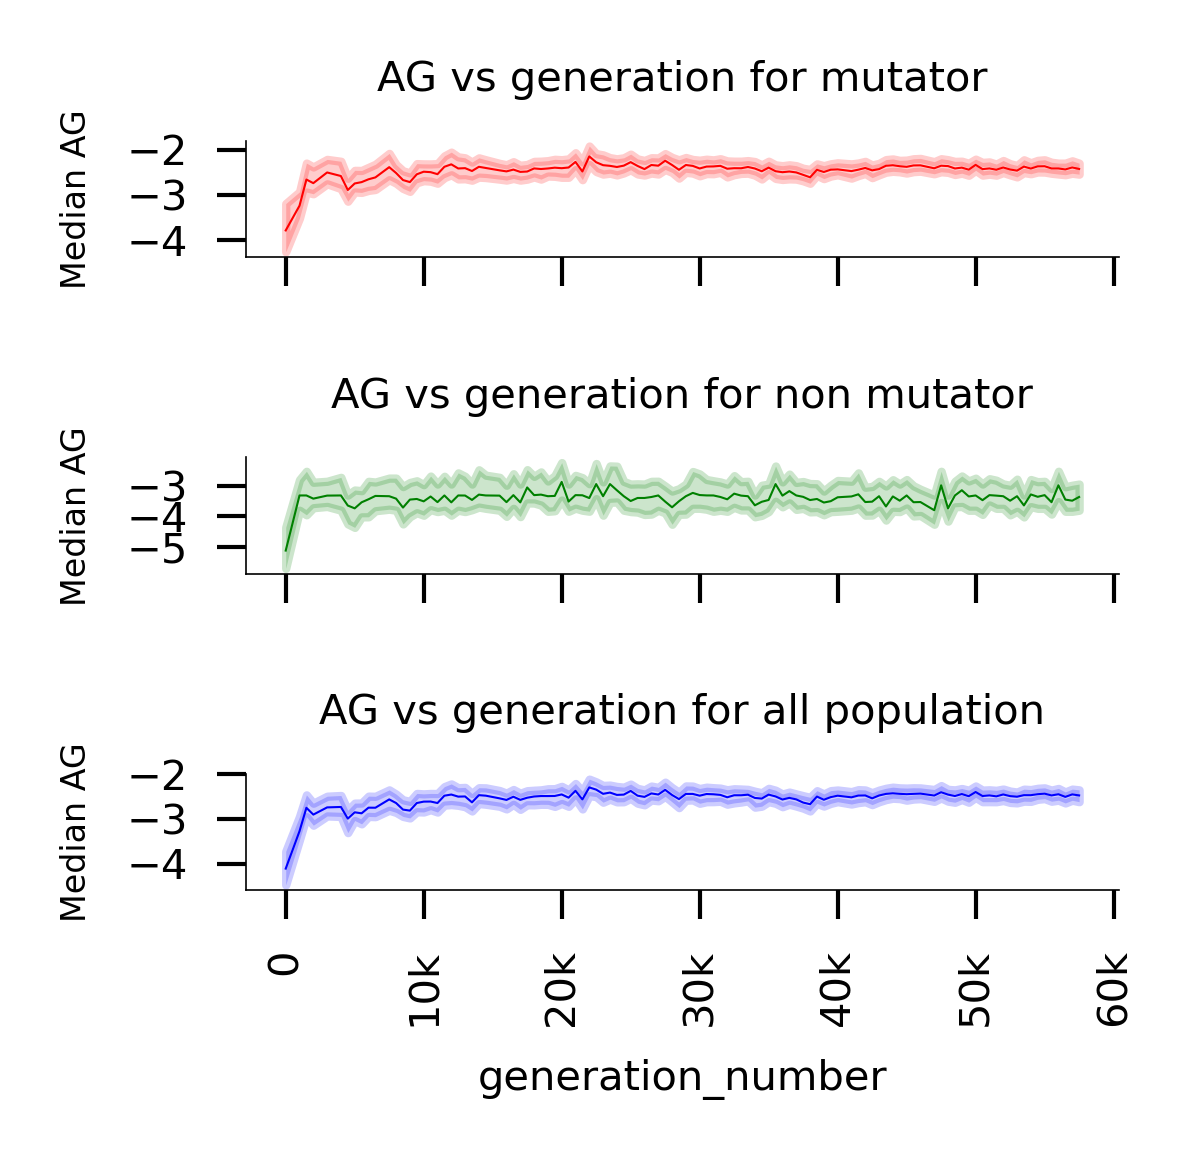

In [22]:
ax = utility.return_mutator_non_mutator_column_name_wise_graph_together(all_mutation, mutator_list, non_mutator_list, column_name = "AG", fontsize = 5);

for i in range(3):
    ax[i] = utility.custom_figure_axis(ax[i], fontsize=5, show_ticks = True);
    ax[i].set_xticks(range(0, 60001, 10000));
#     ax[i].set_title(None)
    
ax[0].set_yticks(np.arange(-4, -1.9, 1));
ax[1].set_yticks(np.arange(-5, -2.4, 1));
ax[2].set_yticks(np.arange(-4, -1.9, 1));
ax[0].set_ylabel("Median AG", fontsize=4);
ax[1].set_ylabel("Median AG", fontsize=4);
ax[2].set_ylabel("Median AG", fontsize=4);
# plt.savefig("ag vs generation in ecoli custom1.pdf", dpi = 600, bbox_inches="tight")

##### divide the data in two group <=30K and >30K and calculate median esm score generation wise and obtain one sided p value

In [23]:
grouped_gen_30K_median_esm = utility.return_generation_grouped_dataframe_with_one_sided_p(all_mutation_with_esm_1b_score_drop_na, column_name = "esm_score", gen_cut_off = 30000, cut_off_string1 =  "<=30K", cut_off_string2 = ">30K")

The one sided man_whiteney p value within the mutator groups for data points <=30K and >30K generation w.r.t esm_score score is:  5.106678392961868e-16
The one sided man_whiteney p value within the non mutator groups for data points <=30K and >30K w.r.t  esm_score score is:  0.19628716652263956


In [24]:
grouped_gen_30K_median_esm.head()

generation_number      mutator  esm_score group_gen
0                  0      mutator  -6.528539     <=30K
1                  0  non mutator  -6.740957     <=30K
2               1000      mutator  -6.197031     <=30K
3               1000  non mutator  -6.801957     <=30K
4               1500      mutator  -6.349631     <=30K

##### box plot of esm score for mutator and non mutator while using 30K generation as cutoff group

###### As a binarized version of Figure 1(C), the boxplot shows the distribution of median LLR scores for generations split into two equal halves (each spanning approximately 30,000 generations). P-values are obtained using the one-sided Mann-Whitney U test. As expected, increase in median LLR score levels among non-mutators appear weaker as compared to mutators.

Text(0.5, 1.0, 'Median LLR score vs mutant type')

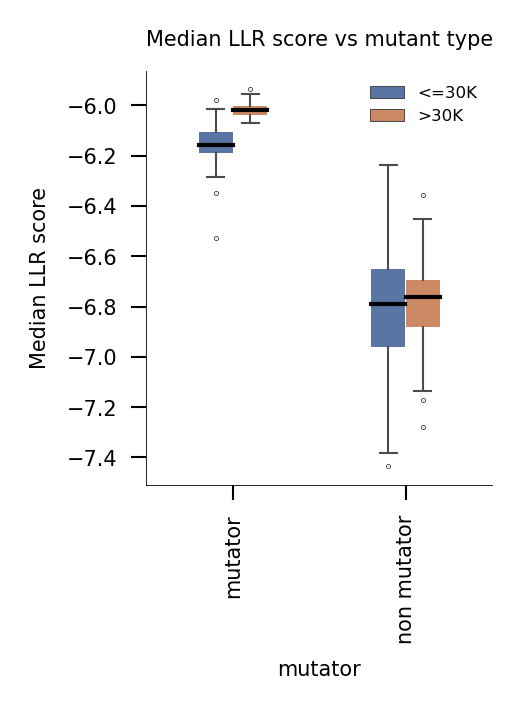

In [25]:
fig, ax = plt.subplots(1, 1 , dpi = 300, figsize = (2.1, 2.1), sharex=True)
sns.set_palette(sns.color_palette('deep'))
sns.boxplot(data=grouped_gen_30K_median_esm, x = "mutator", y = "esm_score", hue= "group_gen", dodge=20, ax = ax, boxprops=dict(edgecolor="black", linewidth=0),flierprops=dict(marker='o', markeredgecolor='black'), width=0.4,linewidth=0.5, fliersize=0.15, medianprops={"color": "black","linewidth":1})
ax.legend(fontsize=4, frameon=False)
plt.tight_layout()
ax = utility.custom_figure_axis(ax, fontsize=5, show_ticks = True)
ax.set_ylabel("Median LLR score")
ax.set_title("Median LLR score vs mutant type", fontsize = 5)
# plt.savefig("esm vs type in ecoli upto 60k gen.pdf", dpi = 600, bbox_inches="tight")

##### divide the data in two group <=30K and >30K and calculate median accumulated gain score generation and mutator type wise and obtain one sided p

In [26]:
grouped_gen_30K_median_ag = utility.return_generation_grouped_dataframe_with_one_sided_p(all_mutation, column_name = "AG", gen_cut_off = 30000, cut_off_string1 =  "<=30K", cut_off_string2 = ">30K")
grouped_gen_30K_median_ag.head()

The one sided man_whiteney p value within the mutator groups for data points <=30K and >30K generation w.r.t AG score is:  0.14572866379465177
The one sided man_whiteney p value within the non mutator groups for data points <=30K and >30K w.r.t  AG score is:  0.7126989340104269


generation_number      mutator        AG group_gen
0                  0      mutator -3.788323     <=30K
1                  0  non mutator -5.117088     <=30K
2               1000      mutator -3.240589     <=30K
3               1000  non mutator -3.318808     <=30K
4               1500      mutator -2.661212     <=30K

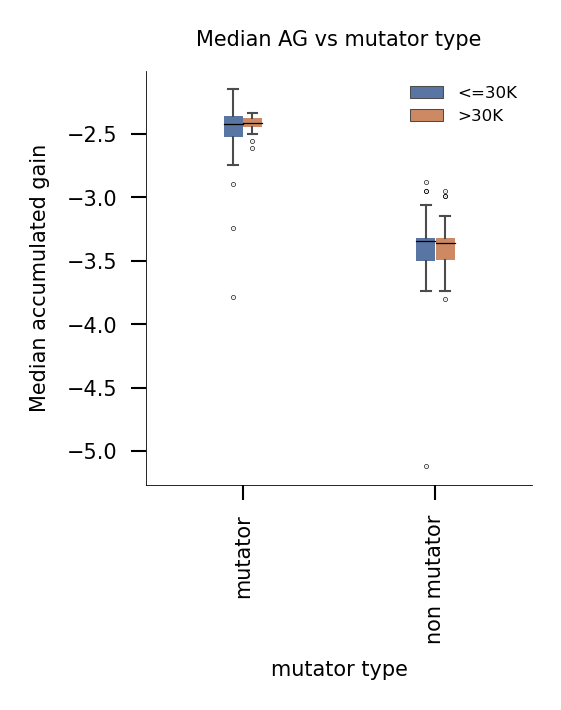

In [27]:
fig, ax = plt.subplots(1, 1 , dpi = 300, figsize = (2.1, 2.1), sharex=True)
sns.set_palette(sns.color_palette('deep'))
sns.boxplot(data=grouped_gen_30K_median_ag, x = "mutator", y = "AG", hue= "group_gen", dodge=20, ax = ax, boxprops=dict(edgecolor="black", linewidth=0),flierprops=dict(marker='o', markeredgecolor='black'), width=0.2,linewidth=0.5, fliersize=0.15, medianprops={"color": "black","linewidth":0.3})
ax.legend(fontsize=4, frameon=False)
plt.tight_layout()
ax = utility.custom_figure_axis(ax, fontsize=5, show_ticks = True)
ax.set_ylabel("Median accumulated gain")
ax.set_xlabel("mutator type")
ax.set_title("Median AG vs mutator type", fontsize = 5)
plt.savefig("AG vs type in ecoli upto 60k gen.pdf", dpi = 600, bbox_inches="tight")

##### Allele change vs accumulated gain for unique mutation 
###### The figure shows a box plot depicting the accumulated gain for each allele change.

/tmp/ipykernel_701410/3076292341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allele_generation["Allele"]= df_allele_generation["Allele"].str.strip()


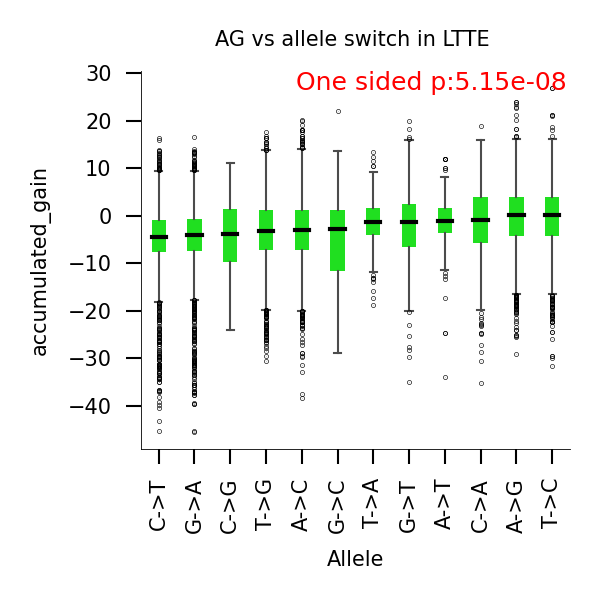

In [28]:

df_allele_generation["Allele"]= df_allele_generation["Allele"].str.strip()
allele_switch_group1 = ['C->G','A->C','A->T','T->G','G->C','T->A', 'C->A',  'G->T'] # Transversion group
allele_switch_group2 = ['G->A', 'C->T', 'A->G','T->C'] # Transition group
df_allele_switch_group1 = df_allele_generation[df_allele_generation["Allele"].isin(allele_switch_group1)]
df_allele_switch_group2 = df_allele_generation[df_allele_generation["Allele"].isin(allele_switch_group2)]

fig, ax = plt.subplots(1, 1, dpi = 300, figsize =(2.1,2.1))
colors = ["lime", "lime", "lime", "lime", "lime", "lime", "lime", "lime", "lime", "lime", "lime", "lime"]
sns.set_palette(sns.color_palette(colors), n_colors=len(colors))
ax = utility.box_plot(data= df_allele_generation, x = 'Allele', y = 'accumulated_gain', ax = ax)
ax = utility.custom_figure_axis(ax, fontsize=5, show_ticks = True)
offset = 0.1
formatted_p = "{:.2e}".format(utility.man_whiteney(df_allele_switch_group2['accumulated_gain'], df_allele_switch_group1['accumulated_gain']))
ax.text((max(ax.get_xlim()) - offset), (max(ax.get_ylim()) - offset), "One sided p:" + formatted_p, fontsize=6, color='red', ha='right', va='top')

ax.set_title("AG vs allele switch in LTTE ", fontsize=5)
plt.tight_layout()
sns.set_palette(sns.color_palette('deep'))

# plt.savefig("accumulated gain vs allele change in ecoli.pdf", dpi = 600, bbox_inches="tight")

##### Accumulated gain vs population for unique mutation

###### The figure presents a box plot depicting the accumulated gain for each population based on the data. The visual evidence show that, without exception, all mutators consistently exhibit a higher median accumulated gain score compared to non-mutators.

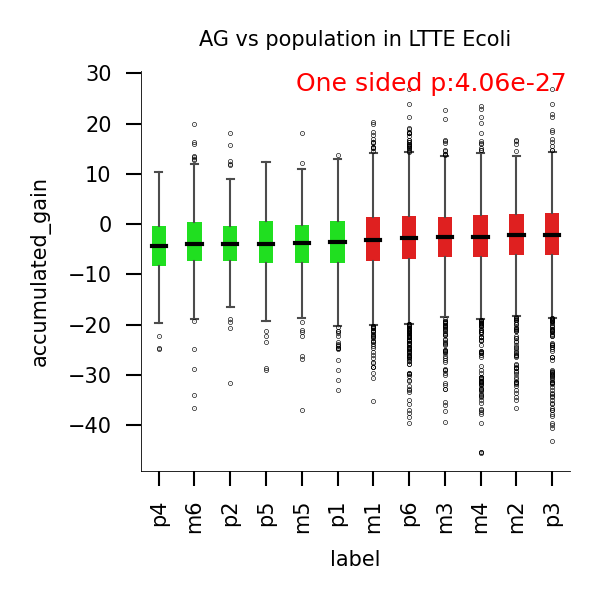

In [29]:
fig, ax = plt.subplots(1, 1, dpi = 300, figsize =(2.1,2.1))
colors = ["lime", "lime", "lime", "lime", "lime", "lime", "red", "red", "red", "red", "red", "red"]
sns.set_palette(sns.color_palette(colors), n_colors=len(colors))
# colors = ["green", "green", "green", "green", "green", "green", "red", "red", "red", "red", "red", "red"]
ax = utility.box_plot(data= df_allele_generation, x = 'label', y = 'accumulated_gain', ax = ax)

ax = utility.custom_figure_axis(ax, fontsize=5, show_ticks = True)
offset = 0.1
formatted_p = "{:.2e}".format(utility.man_whiteney(df_allele_generation[df_allele_generation["label"].isin(mutator_list)]["accumulated_gain"], df_allele_generation[df_allele_generation["label"].isin(non_mutator_list)]["accumulated_gain"]))
ax.text((max(ax.get_xlim()) - offset), (max(ax.get_ylim()) - offset), "One sided p:" + formatted_p, fontsize=6, color='red', ha='right', va='top')
ax.set_title("AG vs population in LTTE Ecoli", fontsize=5)
plt.tight_layout()
sns.set_palette(sns.color_palette('deep'))

##### Find gene wise p value for median esm and median AG score

###### For each gene, we compute the median AG score and median ESM scores with respect to every available generation. Subsequently, the median score for each gene is partitioned into two groups based on a 30,000-generation threshold. The medians score for generations less than or equal to 30,000 are grouped together, while those for generations greater than 30,000 are placed in another group for both AG and ESM. Reporting for a gene is omitted if either of the two scores has fewer than or equal to 15 samples in any of the corresponding groups. Subsequently, for each score, we calculate a one-sided Mann-Whitney test score between the two aforementioned groups. This methodology is iteratively applied to each gene.

In [30]:
p_value_ag_esm = utility.p_value(all_mutation_with_esm_1b_score_drop_na)
p_value_ag_esm.head()

Gene     esm p      ag p  median esm  median AG   mean esm   mean AG
1  yjiH  0.999999  0.988731  -13.425769  -6.307913 -12.670012 -5.883000
3  ompA       1.0  0.000001   -7.370991  -0.563975  -7.093227 -2.274680
4  manY  0.000021  0.000029  -14.936862  -2.871567 -10.126648 -1.766085
6  ycjT  0.526503  0.003156   -9.805831  -5.364291  -7.951155 -4.071982
7  bglF       1.0       0.0   -6.005813  -1.753519  -7.304325 -1.010831

##### calculate generation wise median of fitnesss and esm score for overall population, mutator, non mutator 

In [31]:
all_population_combined_esm_fitness_median = utility.return_combined_fitness_esm_data(df_Fitness2_experimental, all_mutation_with_esm_1b_score_drop_na)

mutator_population_combined_esm_fitness_median =  utility.return_combined_fitness_esm_data(fitness_dataframe = df_Fitness2_experimental[df_Fitness2_experimental["label"].isin(mutator_list)], 
esm_dataframe = all_mutation_with_esm_1b_score_drop_na[all_mutation_with_esm_1b_score_drop_na["label"].isin(mutator_list)])

non_mutator_population_combined_esm_fitness_median =   utility.return_combined_fitness_esm_data(fitness_dataframe = df_Fitness2_experimental[df_Fitness2_experimental["label"].isin(non_mutator_list)], 
esm_dataframe = all_mutation_with_esm_1b_score_drop_na[all_mutation_with_esm_1b_score_drop_na["label"].isin(non_mutator_list)] )

##### Make a scatterplot of median esm vs median fitness for overall population, mutator, non mutator 
###### It is the scatter plot that shows the association between median fitness and median LLR score across generations for the different group. The color gradient depicts generation chronology.

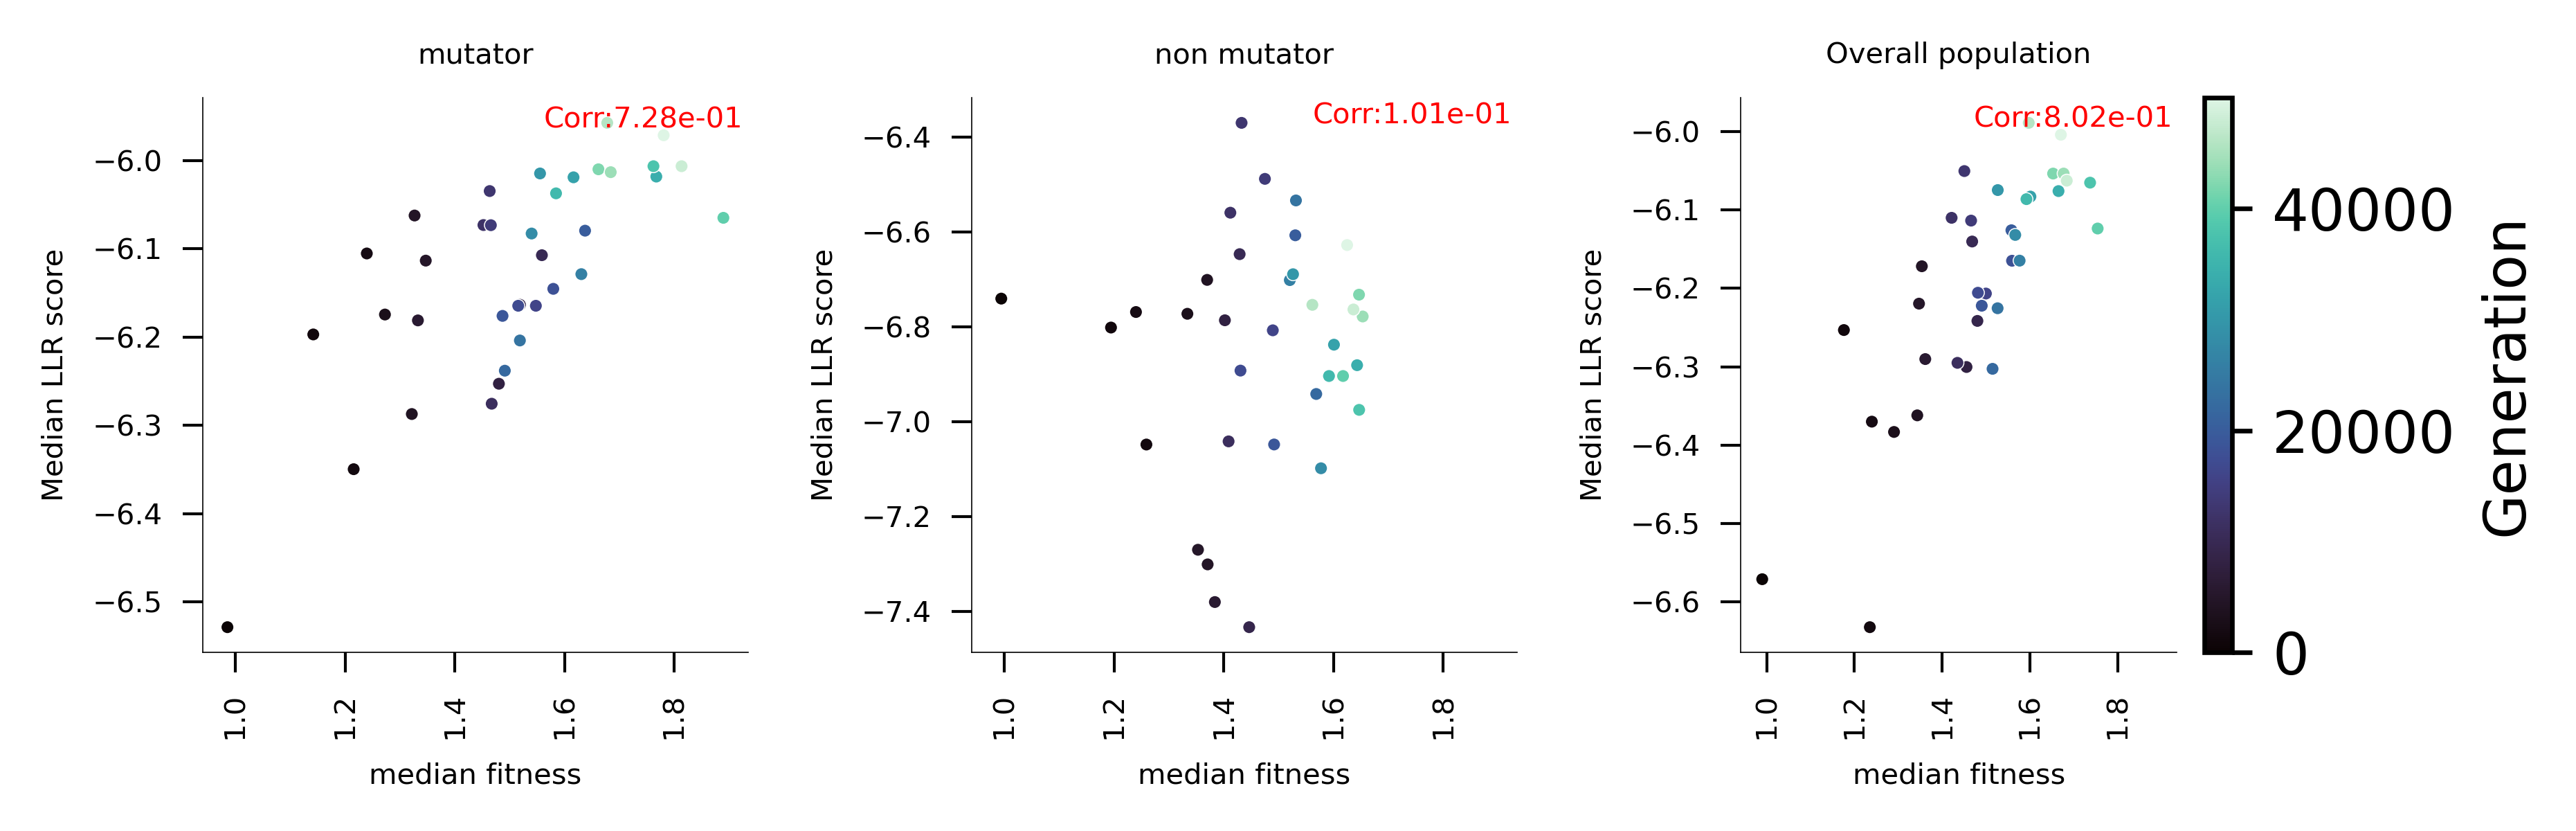

In [32]:
fig, ax = plt.subplots(1,  3, dpi = 600, figsize = (6.3, 2.1), sharex=True)
# sns.color_palette("mako", as_cmap=True)
norm = plt.Normalize(all_population_combined_esm_fitness_median['generation_number'].min(), all_population_combined_esm_fitness_median['generation_number'].max())
sm = plt.cm.ScalarMappable(cmap="mako", norm=norm)
# sm.set_array([])
ax[0] = sns.scatterplot(data= mutator_population_combined_esm_fitness_median, x = "median fitness", y = "median esm_score", hue="generation_number",ax= ax[0], legend=True, s = 5, palette='mako')

ax[1] = sns.scatterplot(data= non_mutator_population_combined_esm_fitness_median, x = "median fitness", y = "median esm_score", hue="generation_number",ax= ax[1], legend=False, s = 5, palette='mako')

ax[2] = sns.scatterplot(data= all_population_combined_esm_fitness_median, x = "median fitness", y = "median esm_score", hue="generation_number",ax= ax[2], legend=False, s = 5, palette='mako')

offset = 0.01

formatted_corr_mutator = "{:.2e}".format(mutator_population_combined_esm_fitness_median["median fitness"].corr(mutator_population_combined_esm_fitness_median["median esm_score"]))
ax[0].text((max(ax[0].get_xlim()) - offset), (max(ax[0].get_ylim()) - offset), "Corr:" + formatted_corr_mutator, fontsize=5, color='red', ha='right', va='top')

formatted_corr_non_mutator = "{:.2e}".format(non_mutator_population_combined_esm_fitness_median["median fitness"].corr(non_mutator_population_combined_esm_fitness_median["median esm_score"]))
ax[1].text((max(ax[1].get_xlim()) - offset), (max(ax[1].get_ylim()) - offset), "Corr:" + formatted_corr_non_mutator, fontsize=5, color='red', ha='right', va='top')

formatted_corr_all = "{:.2e}".format(all_population_combined_esm_fitness_median["median fitness"].corr(all_population_combined_esm_fitness_median["median esm_score"]))
ax[2].text((max(ax[2].get_xlim()) - offset), (max(ax[2].get_ylim()) - offset), "Corr:" + formatted_corr_all, fontsize=5, color='red', ha='right', va='top')


ax[0].set_title("mutator", fontsize=5)
ax[1].set_title("non mutator", fontsize=5)
ax[2].set_title("Overall population", fontsize=5)



for i in range(3):
    ax[i] = utility.custom_figure_axis(ax[i], fontsize=5, show_ticks = True)
    ax[i].set_ylabel("Median LLR score")

ax[0].get_legend().remove()
cbar = fig.colorbar(sm, ax=ax[2])
cbar.set_label('Generation')

# ax[0].figure.colorbar(sm)

plt.tight_layout()

<!-- #### esm score vs generation upto 60K -->

##### Generation vs fitness for mutator and non mutator category

###### It shows the line plots of the median fitness of mutators (six samples pooled) and non-mutators (six samples pooled) across 50,000 generations (Wiser, Ribeck, and Lenski 2013). Standard deviation of the fitness estimates is depicted by error bars. The composite trapezoidal rule is used for computing Area Under the Curve (AUC) associated with the fitness trajectories. Mutators display a marginally greater AUC in their fitness trajectory compared to non-mutators.

In [33]:
df_mutator = df_Fitness2_experimental[df_Fitness2_experimental.loc[:, "Mutator.Ever"]=="Yes"]
df_non_mutator = df_Fitness2_experimental[df_Fitness2_experimental.loc[:, "Mutator.Ever"]=="No"]
grouped_mutator_fitness = df_mutator.groupby('Generation')['Fitness'].agg(['median', 'std']).reset_index()
grouped_non_mutator_fitness = df_non_mutator.groupby('Generation')['Fitness'].agg(['median', 'std']).reset_index()
grouped_mutator_fitness.columns= ['Generation', "Median fitness", "Std of fitness"]
grouped_non_mutator_fitness.columns= ['Generation', "Median fitness", "Std of fitness"]

print("As per the trapezoidal rule, area under the mutator fitness curve across generation is : ", np.trapz(x = grouped_mutator_fitness["Generation"], y = grouped_mutator_fitness["Median fitness"]))
print("As per the trapezoidal rule, area under the non mutator fitness curve across generation is : ", np.trapz(x = grouped_non_mutator_fitness["Generation"], y = grouped_non_mutator_fitness["Median fitness"]))

As per the trapezoidal rule, area under the mutator fitness curve across generation is :  78356.80526875
As per the trapezoidal rule, area under the non mutator fitness curve across generation is :  75857.231003625


##### median fitness vs generation graph

###### It shows the line plots of the median fitness of mutators (six samples pooled) and non-mutators (six samples pooled) across 50,000 generations (Wiser, Ribeck, and Lenski 2013). Standard deviation of the fitness estimates is depicted by error bars. The composite trapezoidal rule is used for computing Area Under the Curve (AUC) associated with the fitness trajectories. Mutators display a marginally greater AUC in their fitness trajectory compared to non-mutators.

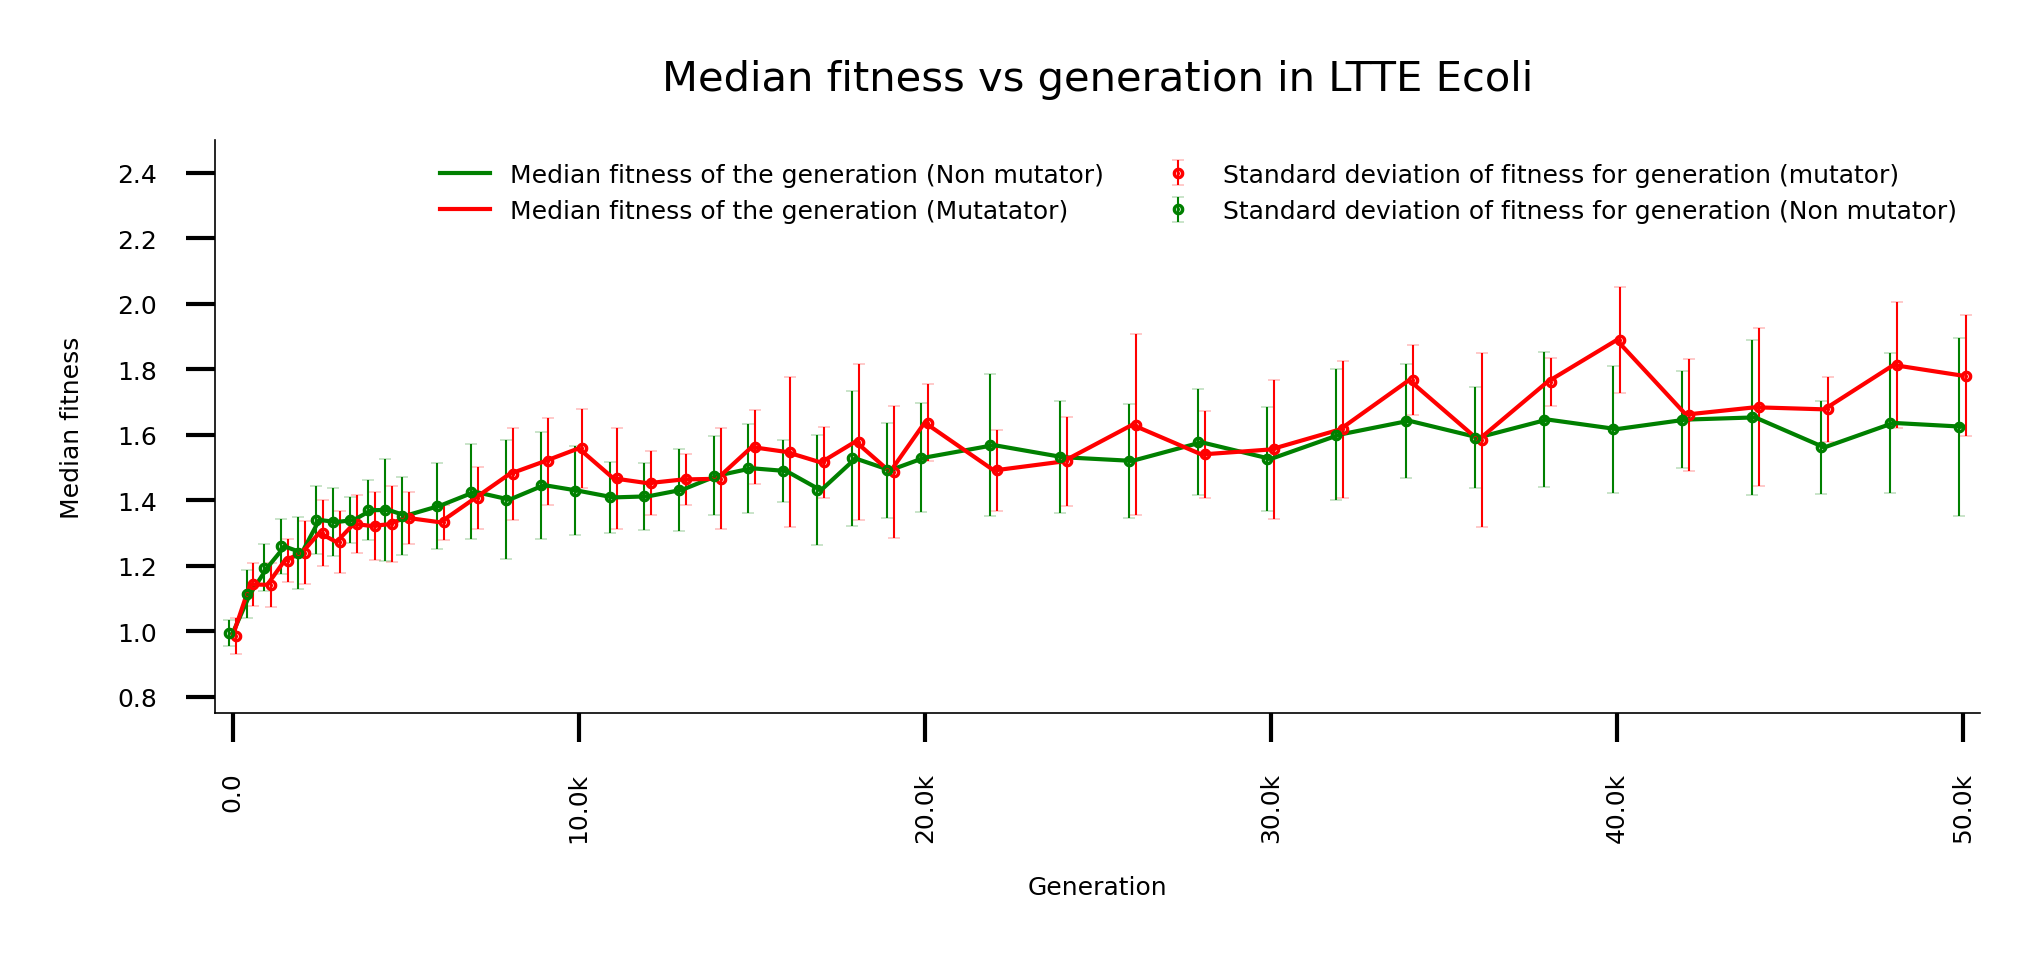

In [34]:
fig, ax = plt.subplots(1, 1 , dpi = 600, figsize = (3.5, 1.7))
from matplotlib.ticker import FuncFormatter

ax.errorbar(x = grouped_mutator_fitness["Generation"]+100, y = grouped_mutator_fitness["Median fitness"], yerr=grouped_mutator_fitness["Std of fitness"], fmt='o', capsize=0.75, label='Standard deviation of fitness for generation (mutator)', capthick=0.05, linewidth=0.25, color = "red", markersize=0.4)
ax.errorbar(x = grouped_non_mutator_fitness["Generation"]-100, y = grouped_non_mutator_fitness["Median fitness"], yerr=grouped_non_mutator_fitness["Std of fitness"], fmt='o', capsize=0.75, label='Standard deviation of fitness for generation (Non mutator)', capthick=0.05, linewidth=0.25, color ="green", markersize=0.4)
ax.plot(grouped_non_mutator_fitness["Generation"], grouped_non_mutator_fitness["Median fitness"], color = "green", label = "Median fitness of the generation (Non mutator)", lw = 0.5)
ax.plot(grouped_mutator_fitness["Generation"], grouped_mutator_fitness["Median fitness"], color ="red", label = "Median fitness of the generation (Mutatator)", lw = 0.5)
ax.legend(ncol=2, fontsize=3, frameon=False)
ax.set_ylim(0.75,2.5)
ax.set_xlim(-500,50500)
ax.set_ylabel("Median fitness")
ax.set_xlabel("Generation")
# Apply the custom tick formatter
formatter = FuncFormatter(utility.format_ticks)
ax.xaxis.set_major_formatter(formatter)
ax = utility.custom_figure_axis(ax, fontsize=3, show_ticks = True)

ax.set_title("Median fitness vs generation in LTTE Ecoli", fontsize=5)
plt.tight_layout()
# plt.savefig("Generation vs fitness in ecoli custom.pdf", dpi = 600, bbox_inches="tight")

##### calculate generation wise median of AG score and log10(median allele count) for overall population, mutator, non mutator 

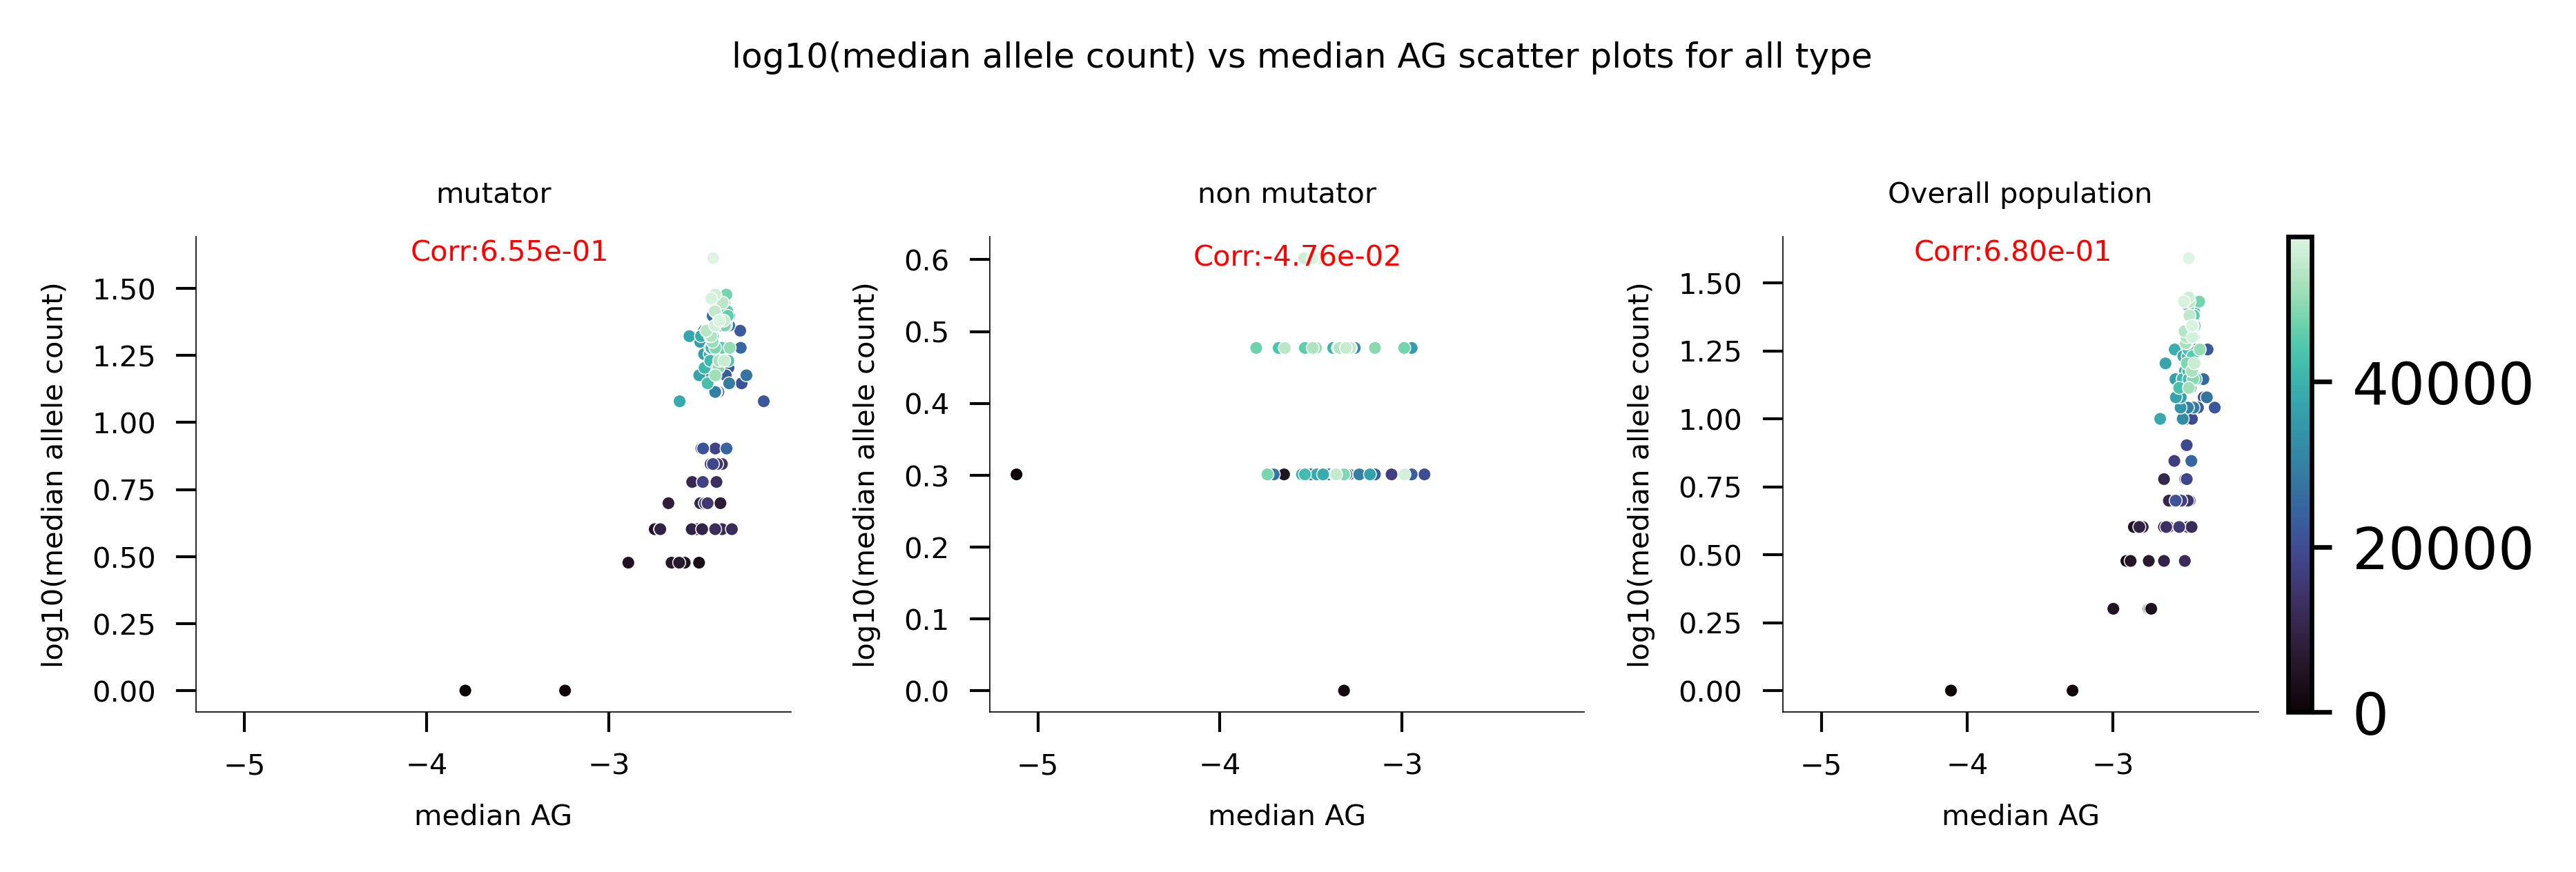

In [35]:
fig, ax = plt.subplots(1,  3, dpi = 600, figsize = (6.3, 2.1), sharex=True)
ax = utility.plot_scatter(all_mutation, mutator_list, non_mutator_list, x_column = "AG", y_column = "allele count", ax=ax)
# plt.savefig("log10 median AC vs median AG score.pdf", dpi = 600, bbox_inches="tight")

##### calculate generation wise median of esm score and log10(median allele count) for overall population, mutator, non mutator 

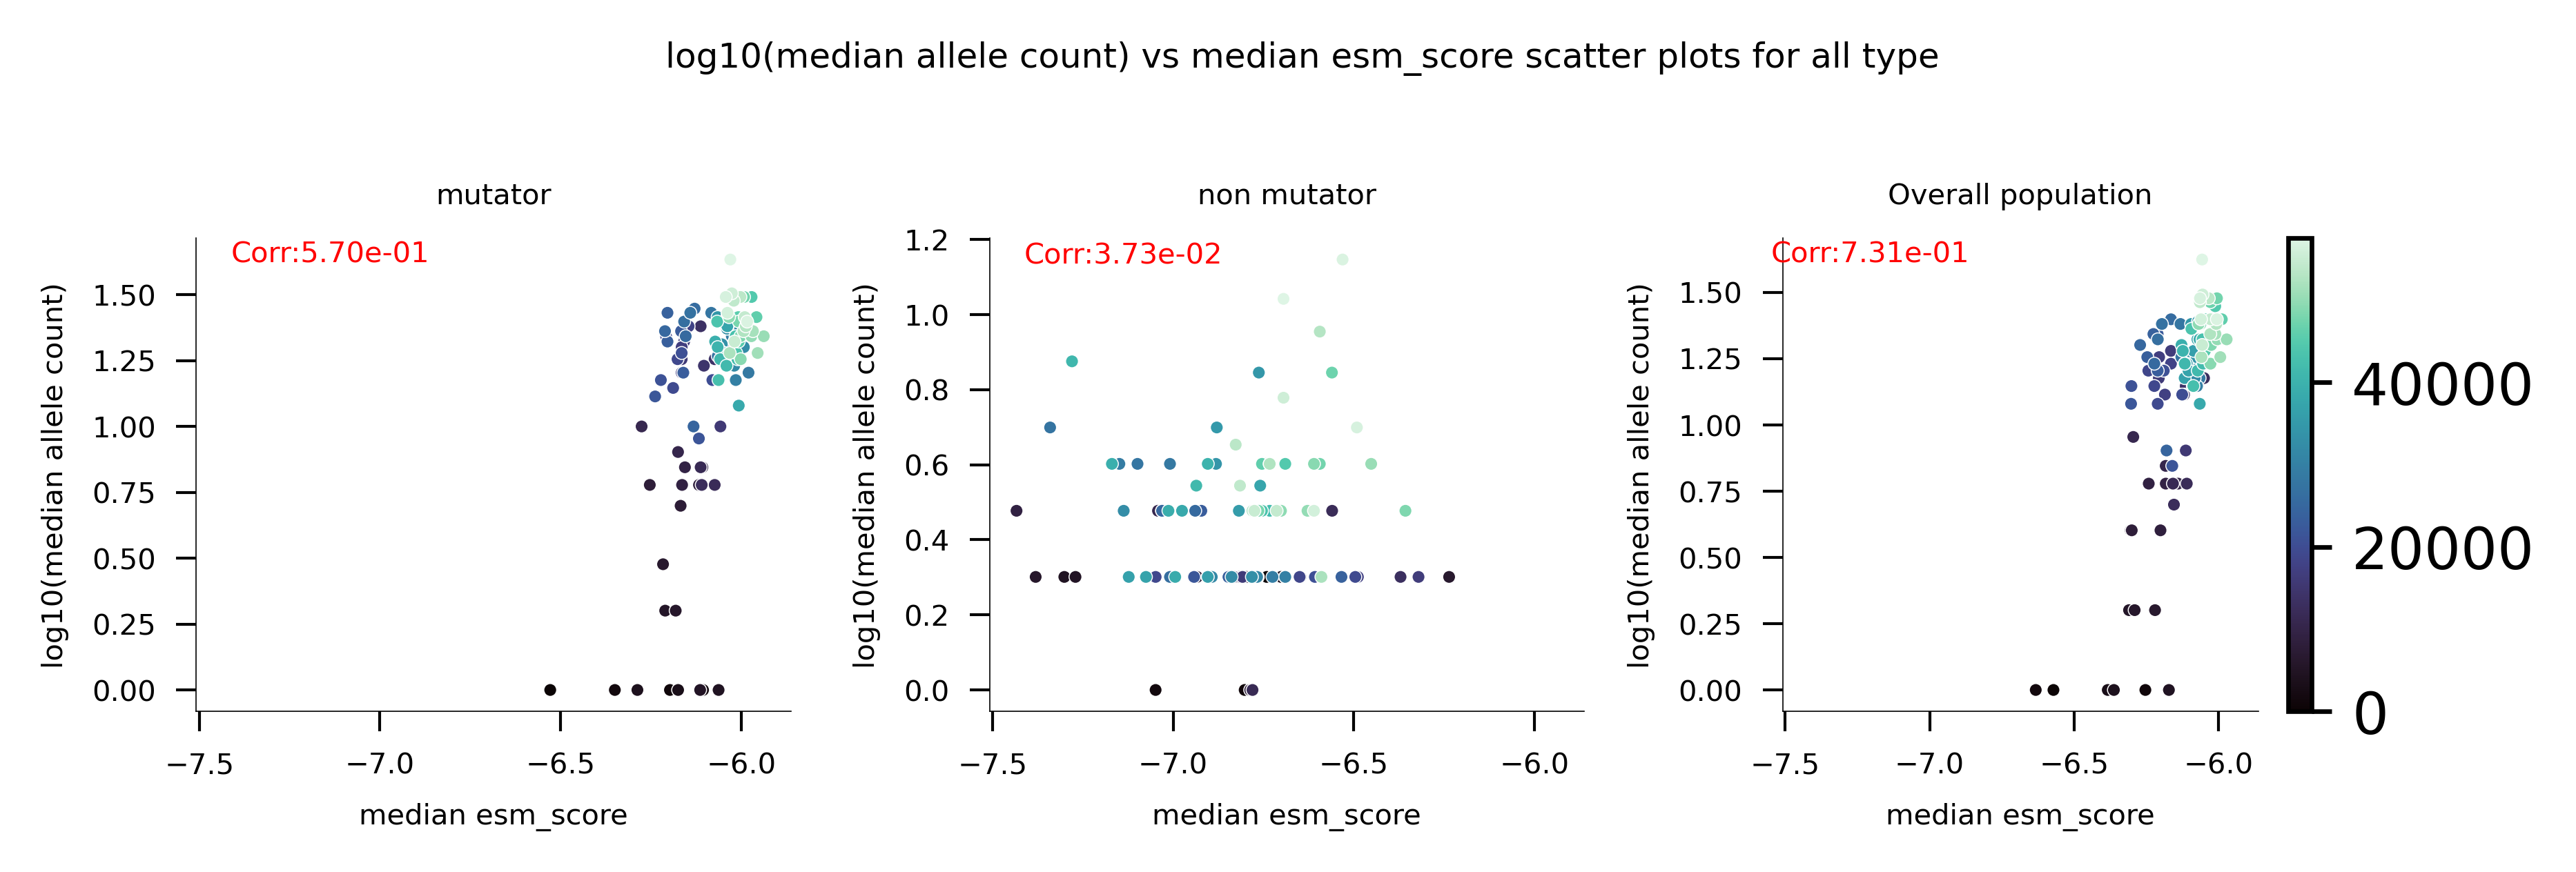

In [36]:
fig, ax = plt.subplots(1,  3, dpi = 600, figsize = (6.3, 2.1), sharex=True)
ax=utility.plot_scatter(all_mutation_with_esm_1b_score_drop_na, mutator_list, non_mutator_list, x_column = "esm_score", y_column = "allele count", ax=ax)
# plt.savefig("log10 median AC vs median esm score.pdf", dpi = 600, bbox_inches="tight")

##### calculate generation wise median of esm score and median of AG for overall population, mutator, non mutator 

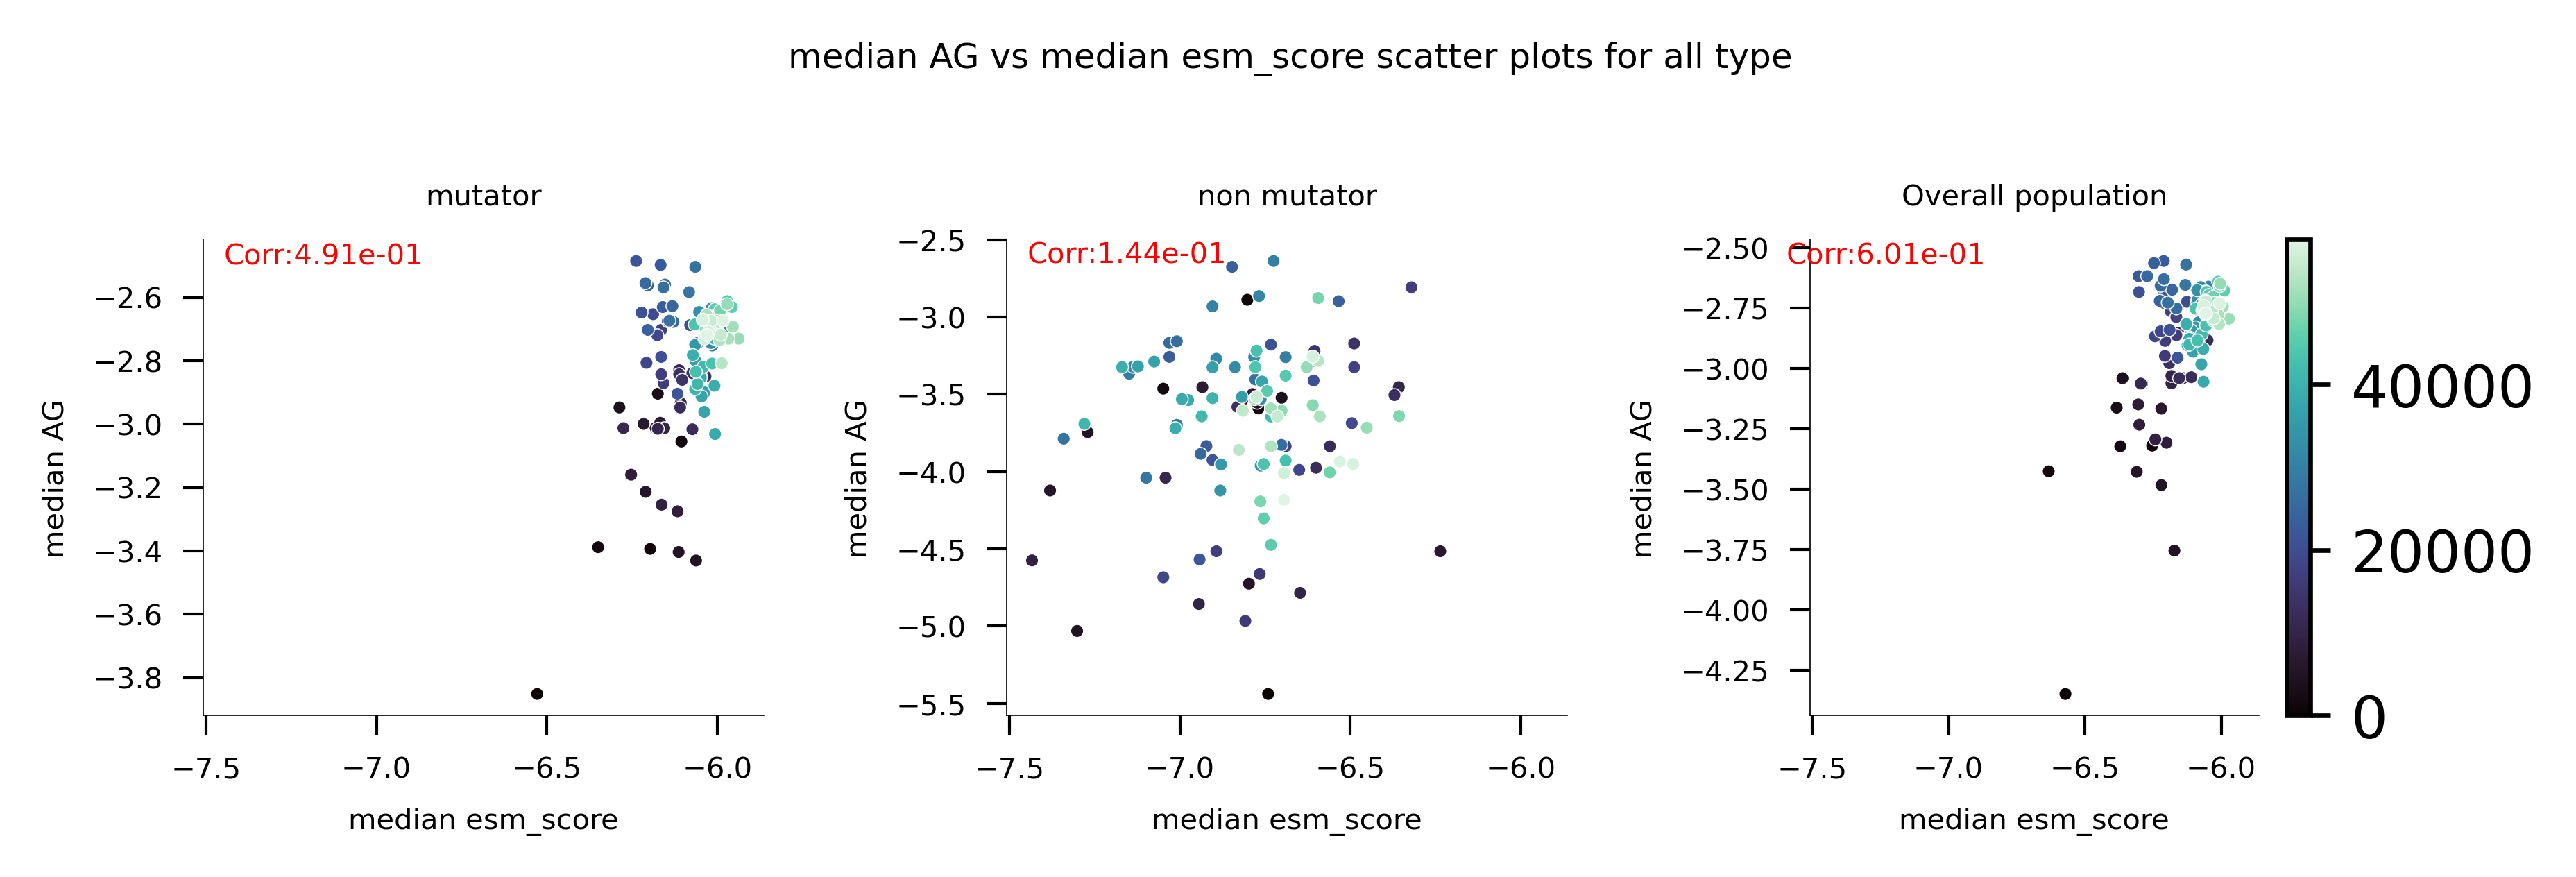

In [37]:
importlib.reload(utility)
fig, ax = plt.subplots(1,  3, dpi = 600, figsize = (6.3, 2.1), sharex=True)
ax = utility.plot_scatter(all_mutation_with_esm_1b_score_drop_na, mutator_list, non_mutator_list, x_column = "esm_score", y_column = "AG", logy = False, ax=ax)
# plt.savefig("median accumulated gain vs median esm in ecoli.pdf", dpi = 600, bbox_inches="tight")